In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import CoolProp.CoolProp as CP
import scipy.optimize as opt
import scipy.integrate


In [4]:
#Konstanten definieren

fluid = 'R717' #Kältemittel

T_Vorlauf = 60+273.15 #Kondensator Vorlauftemperatur in K
T_Ruecklauf = 40+273.15 #Kondensator Ruecklauftemperatur in K (Annahme)
T_u = 4+273.15 #Umgebungstemperatur in K
T_c = 65+273.15 #Kondensator Temperatur in K (Annahme)
T_3sc = 55+273.15 #Kondensator Temperatur in K (Annahme)
T1_sh = 0+273.15 #Temperatur Überhizungung in K (Annahme)

Q_h = 1000000 #Heizleistung in W
p_0 = 3.7e5 #Saugdruck in Pa 
p_c =29.5e5#Hochdruck in PA




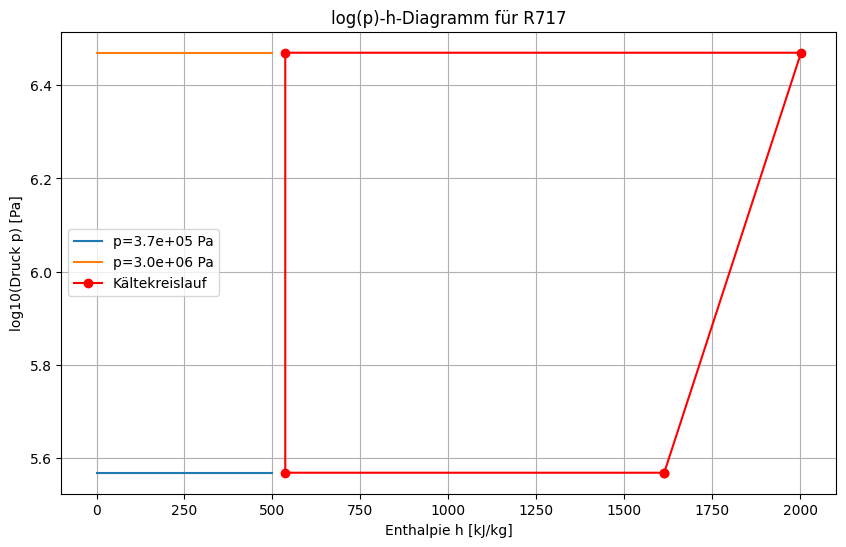

In [5]:
# Zustandspunkte berechnen
# Punkt 1: Austritt Verdampfer (überhitzt)
h1 = CP.PropsSI('H', 'T', T1_sh, 'P', p_0, fluid)  # Enthalpie in J/kg
s1 = CP.PropsSI('S', 'T', T1_sh, 'P', p_0, fluid)  # Entropie in J/kg/K

# Punkt 2: Austritt Verdichter
s2 = s1  # isentrope Verdichtung
h2s = CP.PropsSI('H', 'P', p_c, 'S', s2, fluid)  # isentrope Enthalpie
eta_isentropic = 0.85  # Isentroper Wirkungsgrad
h2 = h1 + (h2s - h1) / eta_isentropic  # tatsächliche Enthalpie
T2 = CP.PropsSI('T', 'P', p_c, 'H', h2, fluid)  # Temperatur

# Punkt 3: Austritt Kondensator
h3 = CP.PropsSI('H', 'T', T_Ruecklauf, 'P', p_c, fluid)  # Enthalpie
s3 = CP.PropsSI('S', 'T', T_Ruecklauf, 'P', p_c, fluid)  # Entropie

# Punkt 4: Austritt Drossel
h4 = h3  # isenthalpische Drosselung
T4 = CP.PropsSI('T', 'P', p_0, 'H', h4, fluid)  # Temperatur

# log(p)-h-Diagramm plotten
h_vals = np.linspace(0, 500000, 500)  # Enthalpie-Werte
p_vals = np.logspace(4, 7, 500)  # Druck-Werte

plt.figure(figsize=(10, 6))
for p in [p_0, p_c]:
    T_vals = CP.PropsSI('T', 'P', p, 'H', h_vals, fluid)
    plt.plot(h_vals / 1000, np.log10(p) * np.ones_like(h_vals), label=f'p={p:.1e} Pa')

# Zustandspunkte eintragen
points_h = [h1, h2, h3, h4, h1]
points_p = [p_0, p_c, p_c, p_0, p_0]
plt.plot(np.array(points_h) / 1000, np.log10(points_p), 'ro-', label='Kältekreislauf')

plt.title('log(p)-h-Diagramm für R717')
plt.xlabel('Enthalpie h [kJ/kg]')
plt.ylabel('log10(Druck p) [Pa]')
plt.legend()
plt.grid()
plt.show()

In [7]:
print (T2-273.15)


184.86902213088996
